In [30]:
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn

In [31]:
# Load data
with open("./voyteklabstudy-default-rtdb-export.json") as f:
    results = json.load(f)
    
X = np.array([results["sigs"]['sig_'+str(49+i)] for i in range(49)])
y = np.zeros_like(X)
for i in range(len(X)):
    start, end = results['ground_truth'][i]
    y[i, start:end+1] = 1

In [32]:
# Sliding window over array
n = 1000
pad = 50

X_roll = np.zeros((len(X), n-int(2*pad), int(2*pad)+1))
y_roll = np.zeros((len(X), n-int(2*pad), int(2*pad)+1))

for i in range(len(X)):
    for j in range(pad, n-pad):
        X_roll[i][j-pad] = X[i, j-pad:j+pad+1]
        y_roll[i][j-pad] = y[i, j-pad:j+pad+1]

X_roll = X_roll - X_roll.mean(axis=2)[:, :, None]
X_roll = X_roll / X_roll.std(axis=2)[:, :, None]

X_roll = np.concatenate((X_roll[:, :, :pad], X_roll[:, :, pad+1:]), axis=2)
y_roll = y_roll[:, :, pad]

X_roll = torch.from_numpy(X_roll).float()
y_roll = torch.from_numpy(y_roll).float()

In [33]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_roll, y_roll, train_size=0.8, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape
X_train = X_train.reshape(-1, int(2*pad))
X_test = X_test.reshape(-1, int(2*pad))
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [34]:
class NN(nn.Module):
    def __init__(self, in_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(2*in_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.seq(x)[:, 0]

In [35]:
model = NN(pad)

# Move the model and tensors to m1/m2 gpu
model = model.to("mps")
X_test = X_test.to("mps")
X_train = X_train.to("mps")
y_test = y_test.to("mps")
y_train = y_train.to("mps")

# Binary cross entropy loss (for 0, 1 predictions)
loss_fn = nn.BCEWithLogitsLoss()

# Gradient descent optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Number of iterations
n_epochs = 10_000

# Training loop
for i in range(n_epochs):

    # Preidct
    y_pred = model(X_train)

    # Compute loss
    loss = loss_fn(y_pred, y_train)

    # Compute gradient
    loss.backward()

    # Step parameters
    optimizer.step()

    # Print progress
    if i % 500 == 0:
        with torch.no_grad():
            y_pred = model(X_test)
            test_loss = loss_fn(y_pred, y_test)
            print(f"Epoch {i}, Train loss = {float(loss)}, Test loss = {test_loss}")

Epoch 0, Train loss = 0.6833924055099487, Test loss = 0.6841177344322205
Epoch 500, Train loss = 0.5897972583770752, Test loss = 0.6020527482032776
Epoch 1000, Train loss = 0.5062939524650574, Test loss = 0.5381723642349243
Epoch 1500, Train loss = 0.43000638484954834, Test loss = 0.46182379126548767
Epoch 2000, Train loss = 0.3646129071712494, Test loss = 0.38463807106018066
Epoch 2500, Train loss = 0.31439080834388733, Test loss = 0.31215691566467285
Epoch 3000, Train loss = 0.2811130881309509, Test loss = 0.25522541999816895
Epoch 3500, Train loss = 0.2605942189693451, Test loss = 0.21685294806957245
Epoch 4000, Train loss = 0.24932989478111267, Test loss = 0.1929629147052765
Epoch 4500, Train loss = 0.24245059490203857, Test loss = 0.17941321432590485
Epoch 5000, Train loss = 0.23754404485225677, Test loss = 0.17252139747142792
Epoch 5500, Train loss = 0.23357316851615906, Test loss = 0.16632920503616333
Epoch 6000, Train loss = 0.23015692830085754, Test loss = 0.16258938610553741


In [36]:
# Results
sigs_train = X_train.reshape(39, -1, 100)[:, :, 50].cpu().numpy()
sigs_test = X_test.reshape(10, -1, 100)[:, :, 50].cpu().numpy()

y_train_pred = model(X_train)
y_train_pred_prob = nn.Sigmoid()(y_train_pred).cpu().detach().numpy().reshape(39, -1)

y_test_pred = model(X_test)
y_test_pred_prob = nn.Sigmoid()(y_test_pred).cpu().detach().numpy().reshape(10, -1)

y_train_true = y_train.cpu().detach().numpy().reshape(39, -1)
y_test_true = y_test.cpu().detach().numpy().reshape(10, -1)

# Plot results
print(y_train_pred)



tensor([-9.5479, -9.5917, -8.2996,  ..., -7.7033, -7.5709, -5.4546],
       device='mps:0', grad_fn=<SelectBackward0>)


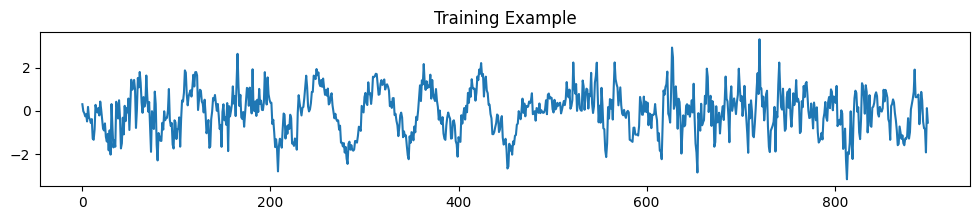

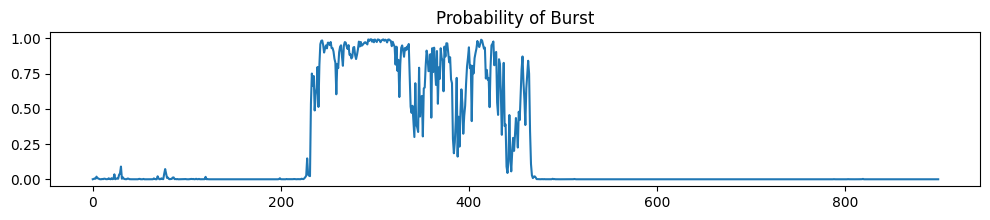

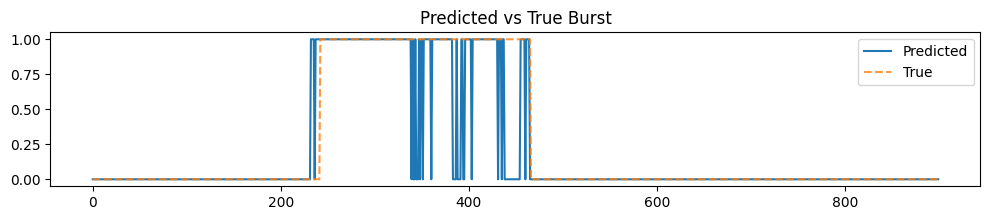

In [37]:
ind = 1

plt.figure(figsize=(12, 2))
plt.title("Training Example")
plt.plot(sigs_train[ind])

plt.figure(figsize=(12, 2))
plt.title("Probability of Burst")
plt.plot(y_train_pred_prob[ind])

plt.figure(figsize=(12, 2))
plt.title("Predicted vs True Burst")
probability_threshold = 0.5
plt.plot(y_train_pred_prob[ind] > probability_threshold, label='Predicted')
plt.plot(y_train_true[ind], color='C1', alpha=.8, ls='--', label='True')
plt.legend();

IndexError: index 31 is out of bounds for axis 0 with size 10

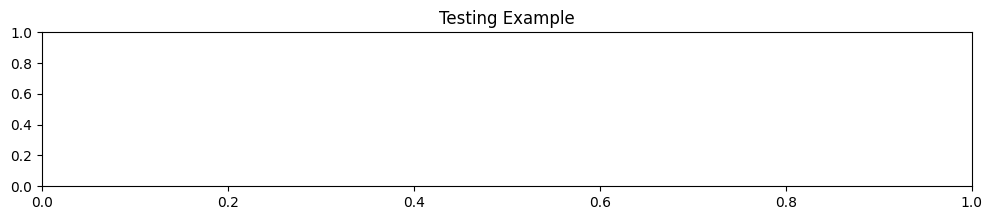

In [38]:
ind = 31

plt.figure(figsize=(12, 2))
plt.title("Testing Example")
plt.plot(sigs_test[ind])

plt.figure(figsize=(12, 2))
y_pred = model(X_test)
y_pred = nn.Sigmoid()(y_pred).cpu().detach().numpy().reshape(10, -1)

plt.title("Probability of Burst")
plt.plot(y_pred[ind])

plt.figure(figsize=(12, 2))
plt.title("Predicted vs True Burst")
probability_threshold = 0.5
plt.plot(y_pred[ind] > probability_threshold, label="Predicted")
plt.plot(y_test.cpu().detach().numpy().reshape(10, -1)[ind], color='C1', alpha=.5, ls='--', label="True");
plt.legend();